In [1]:
import time
import numpy as np
import pandas as pd
import ecnconst
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import HTML

In [3]:
S = ecnconst.TCP_SYN
R = ecnconst.TCP_RST
SA = ecnconst.TCP_SYN | ecnconst.TCP_ACK
SEW = (ecnconst.TCP_SYN | ecnconst.TCP_ECE | ecnconst.TCP_CWR)
SAE = (ecnconst.TCP_SYN | ecnconst.TCP_ECE | ecnconst.TCP_ACK)
SAEW = (ecnconst.TCP_SYN | ecnconst.TCP_ECE | ecnconst.TCP_ACK | ecnconst.TCP_CWR)
QECT = (ecnconst.QOF_ECT0 | ecnconst.QOF_ECT1)
QECT0 = ecnconst.QOF_ECT0
QECT1 = ecnconst.QOF_ECT1
QCE = ecnconst.QOF_CE

In [4]:
RESULT_NOBODYHOME = 0
RESULT_OTHER = 1
RESULT_BROKEN = 2
RESULT_WORKS = 3

# Load data from csv

In [5]:
df = pd.read_csv('meas/m110515_01.csv')
df.shape
#                 names=['site','ip','port','rport','ecnstate','nodeid','connstate','fif','fsf','fuf','fir','fsr','fur','ttl'])

(9998886, 14)

# Cleanup
Remove all flows without SYN

In [6]:
mask_initsyn = (df['fif'] & ecnconst.TCP_SYN) != 0
count_nosyn = df.shape[0] - np.sum(mask_initsyn)
print("Deleting flows without initial SYN: {} of {} ({:.1%}) were affected.".format(count_nosyn, df.shape[0], float(count_nosyn) / df.shape[0]))
df = df[mask_initsyn]
del mask_initsyn

Deleting flows without initial SYN: 11 of 9998886 (0.0%) were affected.


# ECN capability analysis

In [7]:
# ECN flags on TCP layer
df['ecnAttempted'] = np.bitwise_and(df['fsf'], SAEW) == SEW
df['ecnNegotiated'] = np.bitwise_and(df['fsr'], SAEW) == SAE

# ECN flags on IP layer
df["ecnCapable"] = np.bitwise_and(df["fur"], QECT0 << 8) > 0
df["ecnECT1"] = np.bitwise_and(df["fur"], QECT1 << 8) > 0
df["ecnCE"] = np.bitwise_and(df["fur"], QCE << 8) > 0

# check for SYN, SYN+ACK
df["didEstablish"] = ((np.bitwise_and(df["fsf"], S) == S) &
                      (np.bitwise_and(df["fsr"], SA) == SA))

In [8]:
print("Percentage of sucessfully ecn-enabled connections when asking for ecn: {:.2%}".format(
    (df['ecnNegotiated'] & df['connstate']).sum() / (df['ecnAttempted'] & df['connstate']).sum()
    ))

Percentage of sucessfully ecn-enabled connections when asking for ecn: 18.89%


In [9]:
conn_conflict = df[df['connstate'] != df['didEstablish']]
print("Number of connections reported differently by the OS and QoF: {} of {} ({:.2%})".format(conn_conflict.shape[0], df.shape[0], conn_conflict.shape[0] / df.shape[0]))

Number of connections reported differently by the OS and QoF: 99015 of 9998875 (0.99%)


In [10]:
conn_conflict = df[(df['connstate'] == 1) & (df['connstate'] != df['didEstablish'])]
print("Number of connections reported as established by the OS but as failure by QoF: {} of {} ({:.2%})".format(conn_conflict.shape[0], df.shape[0], conn_conflict.shape[0] / df.shape[0]))

Number of connections reported as established by the OS but as failure by QoF: 88765 of 9998875 (0.89%)


In [11]:
conn_conflict = df[(df['connstate'] == 0) & (df['connstate'] != df['didEstablish'])]
print("Number of connections reported as failure by the OS but as success by QoF: {} of {} ({:.2%})".format(conn_conflict.shape[0], df.shape[0], conn_conflict.shape[0] / df.shape[0]))

Number of connections reported as failure by the OS but as success by QoF: 10250 of 9998875 (0.10%)


# Group by endpoints and transform site results to columns

In [12]:
sites = df['site'].unique()

In [13]:
print(time.strftime("%H:%M:%S"))

22:42:26


In [14]:
incomplete_groups = set()
dfa = []
i = 0
j = 0
t0 = time.time()
for name, group in df.groupby(by='ip'):
    if i == 50000:
        print(time.strftime("%H:%M:%S"), j)
        i = 0
    i+=1
    j+=1
    
    cols = {'ip':group['ip'].iloc[0], 'port':group['port'].iloc[0]}
    for site, gsite in group.groupby(by='site'):
        #gsite = group[group['site'] == site]
        try:
            if gsite.iloc[0]['ecnstate'] == 1:
                ecn_on = gsite.iloc[0]
                ecn_off = gsite.iloc[1]
            else:
                ecn_off = gsite.iloc[0]
                ecn_on = gsite.iloc[1]
        except IndexError:
            incomplete_groups.add(group['ip'].iloc[0])
            break
        
        if ecn_off['connstate'] and ecn_on['connstate']:
            result = RESULT_WORKS
        elif ecn_off['connstate'] and not ecn_on['connstate']:
            result = RESULT_BROKEN
        elif not ecn_off['connstate'] and not ecn_on['connstate']:
            result = RESULT_NOBODYHOME
        else:
            result = RESULT_OTHER
        
        cols['result-'+site] = result
        cols['ecnNegotiated-'+site] = ecn_on['ecnNegotiated']
        cols['ttl-'+site] = ecn_off['ttl']
    dfa.append(cols)
t1 = time.time()
print(t1 - t0)

22:45:19 50000
22:47:56 100000
22:50:30 150000
22:53:04 200000
22:55:37 250000
22:58:10 300000
23:00:43 350000
23:03:16 400000
23:05:47 450000
23:08:16 500000
23:10:45 550000
23:13:15 600000
23:15:44 650000
23:18:13 700000
23:20:42 750000
23:23:10 800000
23:25:38 850000
23:28:07 900000
23:30:35 950000
3029.124983072281


In [32]:
dfg = pd.DataFrame(dfa)
dfg.to_csv('meas/m110515_01.grouped.csv')

In [33]:
dfg = pd.read_csv('meas/m110515_01.grouped.csv')

# Is dataset complete?

In [35]:
if len(incomplete_groups) > 0:
    print("Warning: There are {} ips where measurement results are missing from one or more vantage points.".format(len(incomplete_groups)))
    print(",".join(incomplete_groups))
else:
    print("OK! All ips have measurement results from all vantage points.")

119.246.176.229,123.131.138.202,36.231.105.211,188.76.83.224,202.22.232.136,79.114.112.135,176.215.42.168,5.129.253.110,61.227.230.243,122.7.213.247,124.244.121.203,101.50.46.49,14.200.74.231,207.172.189.137,211.223.80.37,24.177.216.101,188.78.209.52,60.56.196.50,71.125.19.60,85.130.43.181,27.32.142.96,75.187.54.186,58.168.1.107,1.173.53.88,90.202.25.186,182.201.137.35,37.98.253.90,111.255.38.185,176.187.236.30,71.95.52.230,118.168.166.162,199.193.118.112,2.226.238.140,175.108.202.76,177.37.126.153,105.229.21.86,109.26.6.99,5.189.30.213,77.175.235.182,70.73.155.56,92.98.41.132,121.170.38.183,14.201.123.138,118.32.45.220,180.197.39.58,121.211.100.121,183.141.142.130,211.30.152.52,101.127.6.154,176.192.248.50,5.143.110.98,174.51.192.126,14.47.49.93,72.185.239.126,109.189.205.241,82.224.246.215,222.251.146.156,46.73.151.21,24.113.67.36,73.181.59.80,60.34.113.132,119.49.205.78,176.193.99.50,81.66.26.39,66.86.125.115,178.140.180.195,1.161.85.199,182.165.96.68,24.254.158.64,74.136.41.59,73.9

# Results

In [73]:
# offline: never made any successful connection
mask_offline = dfg['result-'+sites].apply(lambda x: x == RESULT_NOBODYHOME, reduce=False).all(axis=1)
df_online = dfg[-mask_offline]

num_offline = (mask_offline.sum())
num_online = (-mask_offline).sum()
print("online: {} ({:.2%})".format(num_online, num_online/dfg.shape[0]))

online: 687089 (68.71%)


In [74]:
# always works without ECN and with ECN
mask_works = df_online['result-'+sites].apply(lambda x: x == RESULT_WORKS, reduce=False).all(axis=1)
df_works = df_online[mask_works]
num_works = mask_works.sum()

print("works all path: {} ({:.3%})".format(num_works, num_works/num_online))

# gather the rest
num_works_not = (np.logical_not(mask_works)).sum()
df_works_not = df_online[np.logical_not(mask_works)]

works all path: 634426 (92.335%)


In [75]:
# always works without ECN but never with ECN
mask_totally_broken = df_works_not['result-'+sites].apply(lambda x: x == RESULT_BROKEN, reduce=False).all(axis=1)
df_totally_broken = df_works_not[mask_totally_broken]
num_totally_broken = mask_totally_broken.sum()

print("always works without ECN but never with ECN: {} ({:.3%})".format(num_totally_broken, num_totally_broken/num_online))

# gather the rest
num_totally_broken_not = (np.logical_not(mask_totally_broken)).sum()
df_totally_broken_not = df_works_not[np.logical_not(mask_totally_broken)]

always works without ECN but never with ECN: 1441 (0.210%)


In [76]:
mask_works_per_site = df_totally_broken_not['result-'+sites].apply(lambda x: (x == RESULT_WORKS) | (x == RESULT_NOBODYHOME), reduce=False).all(axis=1)
df_works_per_site = df_totally_broken_not[mask_works_per_site]
num_works_per_site = mask_works_per_site.sum()
print("either works with and without ECN or not at all: {} ({:.3%})".format(num_works_per_site, num_works_per_site/num_online))

# gather the rest
num_works_per_site_not = (np.logical_not(mask_works_per_site)).sum()
df_works_per_site_not = df_totally_broken_not[np.logical_not(mask_works_per_site)]

either works with and without ECN or not at all: 9936 (1.446%)


In [77]:
print("transient/other: {} ({:.3%})".format(num_works_per_site_not, num_works_per_site_not/num_online))

transient/other: 41286 (6.009%)


## TTL analysis

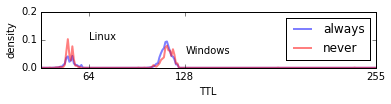

In [90]:
# Negotiation TTL spectrum
def ttl_spectrum(df, col):
    grp = df.groupby(np.digitize(df[col], np.linspace(0,255,256)))
    ser = grp[col].count() / len(df)
    ser.index = ser.index + (-1)
    ser = ser.reindex(np.linspace(0,255,256), fill_value=0)
    return ser

ttl_col = 'ttl-lon'

ettl = ttl_spectrum(df_works,ttl_col)
nttl = ttl_spectrum(df_totally_broken,ttl_col)

plt.figure(figsize=(6,1))
plt.plot(ettl.index, ettl, color="b", lw=2, alpha=0.50, label="always")
plt.plot(nttl.index, nttl, color="r", lw=2, alpha=0.50, label="never")
plt.annotate("Linux", xy=(65,0.1))
plt.annotate("Windows", xy=(129,0.05))
plt.legend()
plt.xlim(32,255)
plt.yticks([0,0.1,0.2])
plt.xticks([64,128,255])
plt.ylabel("density")
plt.xlabel("TTL")
plt.savefig("connttl.png", dpi=120, bbox_inches="tight")

In [86]:
HTML("<table><tr><th></th><th>Linux</th><th>Windows</th></tr>"
     "<tr><td style=\"color:blue;font-weight:bold;\">always</td><td>{}</td><td>{}</td></tr>"
     "<tr><td style=\"color:red;font-weight:bold;\">never</td><td>{}</td><td>{}</td></tr>"
     "<tr><td style=\"color:purple;font-weight:bold;\">other</td><td>{}</td><td>{}</td></tr></table>".format(
     (df_works[ttl_col] <= 64).sum(), (df_works[ttl_col] > 64).sum(),
     (df_totally_broken[ttl_col] <= 64).sum(), (df_totally_broken[ttl_col] > 64).sum(),
     (df_works_per_site_not[ttl_col] <= 64).sum(), (df_works_per_site_not[ttl_col] > 64).sum()))

,Linux,Windows
always,167595,466831
never,557,884
other,29202,11024


In [87]:
HTML("<table><tr><th></th><th>Linux</th><th>Windows</th></tr>"
     "<tr><td style=\"color:blue;font-weight:bold;\">always</td><td>{} ({:.2%})</td><td>{} ({:.2%})</td></tr>"
     "<tr><td style=\"color:red;font-weight:bold;\">never</td><td>{} ({:.2%})</td><td>{} ({:.2%})</td></tr>"
     "<tr><td style=\"color:purple;font-weight:bold;\">other</td><td>{} ({:.2%})</td><td>{} ({:.2%})</td></tr></table>".format(
     (df_works[ttl_col] <= 64).sum(), (df_works[ttl_col] <= 64).sum()/num_online, (df_works[ttl_col] > 64).sum(), (df_works[ttl_col] > 64).sum()/num_online,
     (df_totally_broken[ttl_col] <= 64).sum(), (df_totally_broken[ttl_col] <= 64).sum()/num_online,(df_totally_broken[ttl_col] > 64).sum(),(df_totally_broken[ttl_col] > 64).sum()/num_online,
     (df_works_per_site_not[ttl_col] <= 64).sum(), (df_works_per_site_not[ttl_col] <= 64).sum()/num_online, (df_works_per_site_not[ttl_col] > 64).sum(), (df_works_per_site_not[ttl_col] > 64).sum()/num_online))

,Linux,Windows
always,167595 (24.39%),466831 (67.94%)
never,557 (0.08%),884 (0.13%)
other,29202 (4.25%),11024 (1.60%)


In [47]:
df_works['ecnNegotiated-lon'].sum()/len(df_works)

0.18948309180266887

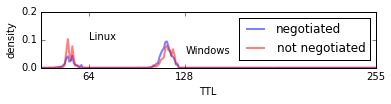

In [54]:
ttl_col = 'ttl-lon'
ecnNegotiated_col = 'ecnNegotiated-lon'

nego_ettl = ttl_spectrum(df_works[df_works[ecnNegotiated_col]],ttl_col)
nego_nttl = ttl_spectrum(df_works[np.logical_not(df_works[ecnNegotiated_col])],ttl_col)

plt.figure(figsize=(6,1))
plt.plot(ettl.index, ettl, color="b", lw=2, alpha=0.50, label="negotiated")
plt.plot(nttl.index, nttl, color="r", lw=2, alpha=0.50, label="not negotiated")
plt.annotate("Linux", xy=(65,0.1))
plt.annotate("Windows", xy=(129,0.05))
plt.legend()
plt.xlim(32,255)
plt.yticks([0,0.1,0.2])
plt.xticks([64,128,255])
plt.ylabel("density")
plt.xlabel("TTL")
plt.savefig("negottl.png", dpi=120, bbox_inches="tight")

In [88]:
df_works_ecn = df_works[df_works[ecnNegotiated_col]]
df_works_ecn_not = df_works[np.logical_not(df_works[ecnNegotiated_col])]

HTML("<table><tr><th style=\"color:blue;font-weight:bold;\">always</th><th>Linux</th><th>Windows</th></tr>"
     "<tr><td style=\"font-weight:bold;\">negotiated</td><td>{} ({:.0%})</td><td>{} ({:.0%})</td></tr>"
     "<tr><td style=\"font-weight:bold;\">not negotiated</td><td>{} ({:.0%})</td><td>{} ({:.0%})</td></tr></table>".format(
    (df_works_ecn[ttl_col] <= 64).sum(), (df_works_ecn[ttl_col] <= 64).sum()/len(df_works),
    (df_works_ecn[ttl_col] > 64).sum(), (df_works_ecn[ttl_col] > 64).sum()/len(df_works),
    (df_works_ecn_not[ttl_col] <= 64).sum(), (df_works_ecn_not[ttl_col] <= 64).sum()/len(df_works),
    (df_works_ecn_not[ttl_col] > 64).sum(), (df_works_ecn_not[ttl_col] > 64).sum()/len(df_works)))

always,Linux,Windows
negotiated,114432 (18%),5781 (1%)
not negotiated,53163 (8%),461050 (73%)


### ECN site & path analysis

In [57]:
#ecn_nego_on_attempt = ((df_online[mask_works])['prop-negotiated'] > 0).sum()
#print("{} ({:.2%}): Number of connections where ecn has actually been negotiated on successful connect.".format(ecn_nego_on_attempt, ecn_nego_on_attempt / ecn_understood_all_mask.sum()))

(1829264, 4851726)

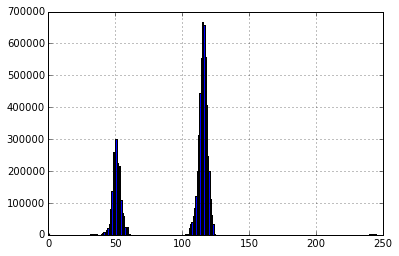

In [58]:
df[df['connstate']]['ttl'].hist(bins=255)
(df['connstate'] & (df['ttl'] < 80)).sum(), (df['connstate'] & (df['ttl'] > 80)).sum()
#df[df['connstate']].sort('ttl')